## Evaluating tests

This is a notebook discussing how one might evaluate a null-hypothesis significance test, to determine the best test for a given situations.

In particular, there are a few important issues.

First, you need the right test, that measures what you want to measure. That's pretty clear.

Next, many tests rely on certain assumptions about your data. While on the high level that's a yes-or-no question, in practice your data might not quite fit the assumptions, the distribution might not be quite normal, the  distributions might change over time. So it's also a question of how robust the test is to violations of the assumptions? In particular, what is the effect of the on the distribution of the p-values?

It's not clear to me how to measure this yet.

Finally, how powerful is the test? what's the power of the test, given an effect size and a false-positive rate? The is probably best measured through the area under what I call an alpha-beta curve, below.

In [1]:
import sys
sys.path.append('/Users/jackbennetto/git/graphing_tools/')

In [6]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvalues
import sys
sys.path.append('/Users/bennetto/git')
from graphing_tools import tools
%matplotlib inline

Some code to examine p-values.

In [8]:
data = stats.uniform(0, 1).rvs(100)

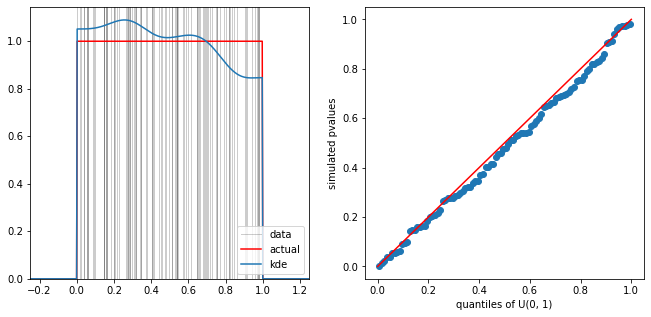

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
pvalues.plot_pvalues(ax[0],
                     data)
pvalues.plot_quantiles(ax[1],
                       data)

### alpha-beta curve

An alpha-beta curve (my term) is a way of measuring the overall power of a test, given a particular alternative hypothesis.  Rather than measuring the power at a single threshold or value of alpha, it plots alpha against beta.

This is analogous to an ROC curve. We can investigate it in the same way we'd look at the probabilistic interpretation of an ROC curve, with samples from one class ($H_0$) along the horizontal axis, and from the other ($H_A$) along the vertical, both ordered by increasing p-values.

Note that significant constraint of this approach is we need to consider an specific alternative hypothesis. Later we'll consider some parameterized $H_A$ and plot that parameter against the AUC.

To start, we'll consider a simple problem: determining if a set of points fit the normal distribution. We'll consider a few different options, using a few different alternative hypotheses.

It takes as input two random variables and a test statistic that operates on two samples. It is parameterized by the critical value. For each critical value, it plots the alpha (false-positive rate) for rejecting that two samples taken from the first are from the same distribution, against the beta (false negative rate) that samples taken form the each fail to reject the null.

In [46]:
def alpha_beta_plot(ax,
                    dist1, dist2,
                    sample_size,
                    statistic,
                    n_samples=10,
                    increasing=True,
                    draw_lines=False):
    # get samples from null and alternative distributions
    data1 = dist1.rvs((sample_size, n_samples))
    data2 = dist2.rvs((sample_size, n_samples))
    
    # calculate statistic between pairs within 
    stats_11 = np.zeros((n_samples, n_samples))
    stats_12 = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            stats_11[i, j] = statistic(data1[:, i], data1[:, j])[0]
            stats_12[i, j] = statistic(data1[:, i], data2[:, j])[0]
    stats_11 = stats_11[np.tril_indices(n_samples, -1)]
    stats_12 = stats_12.flatten()
    print(stats_11.shape, stats_12.shape)
    merged = np.concatenate([stats_11, stats_12])
    merged.sort()
    
    alphas = np.zeros_like(merged)
    betas = np.zeros_like(merged)

    for i, crit in enumerate(merged):
        alphas[i] = ((crit > stats_11).sum()/len(stats_11))
        betas[i] = ((crit < stats_12).sum()/len(stats_12))

    #tools.multihist([stats_11, stats_12], ax=ax, bins=50)
    #ax.hist(stats_11, alpha=0.3, bins=30, label='stats_11', density=True)
    #ax.hist(stats_12, alpha=0.3, bins=30, label='stats_12', density=True)
    #ax.legend()
    #return
    
    if draw_lines:
        for alpha in np.unique(alphas):
            ax.axvline(alpha, lw=0.2)
        for beta in np.unique(betas):
            ax.axhline(beta, lw=0.2)

    ax.plot(alphas, betas, 'ko-')
    ax.set_xlabel("alpha")
    ax.set_ylabel("beta")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    return ((stats_11 > stats_12[:, None]).mean() +
            (stats_11 == stats_12[:, None]).mean()/2)


(10,) (25,)


0.968

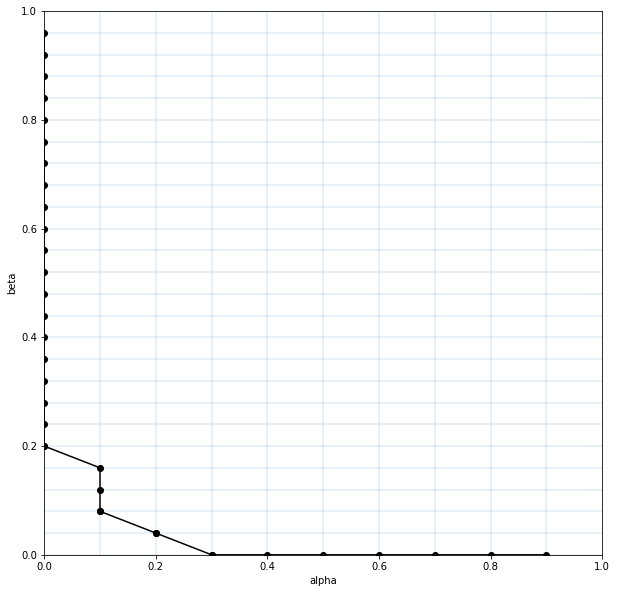

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

alpha_beta_plot(ax,
                stats.norm(0, 1),
                stats.norm(0.5, 1),
                sample_size=20,
                statistic=stats.ttest_ind,
                n_samples=5,
                draw_lines=True)

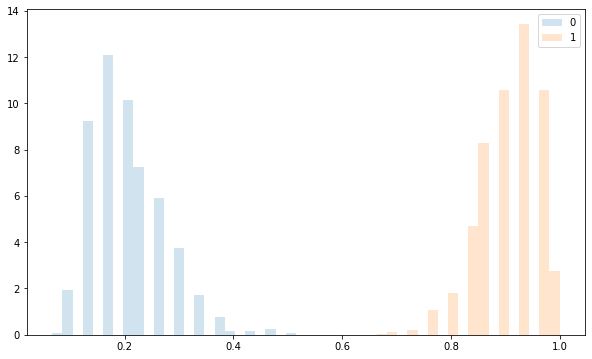

In [358]:
fig, ax = plt.subplots(figsize=(10, 6))

alpha_beta_plot(ax,
                stats.norm(0, 1),
                stats.norm(3, 1),
                30,
                stats.kstest,
                50)

Why is this going the other direction? Need to read about 

In [359]:
stats.kstest([1,2,3,4,5], [2,3,4,5,6])

KstestResult(statistic=0.2, pvalue=1.0)

Idea: test that includes whether gaps are bigger or smaller, and uses that in the test statistic. Try to make the statistic distribution free.

Think of ways the ordering and layout of element changes when we change the distribution, and look for things that change when you change the underlying distribution, and then you can measure anything that keeps that constant

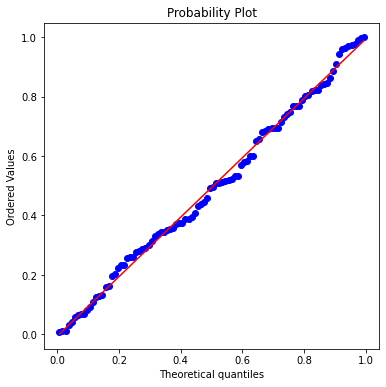

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
#ax.plot([0, 1], [0, 1])
stats.probplot(data,
               dist=stats.uniform(0, 1),
               fit=False,
               plot=ax);

In [112]:
import scipy

In [113]:
scipy.__version__

'1.4.1'

In [14]:
import scipy

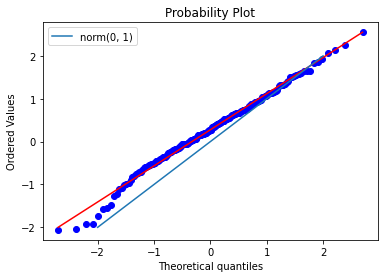

In [33]:
data = scipy.stats.norm(0.3, 0.8).rvs(200)
# Do these data come from norm(0, 1)?
fig, ax = plt.subplots()
scipy.stats.probplot(data,
                     dist=stats.norm(0, 1),
                     fit=False,
                     plot=ax)
ax.plot([-2, 2], [-2, 2],
        label="norm(0, 1)")
ax.legend()

In [30]:
import sys, scipy, numpy; print(scipy.__version__, numpy.__version__, sys.version_info)

1.6.0 1.19.2 sys.version_info(major=3, minor=9, micro=1, releaselevel='final', serial=0)


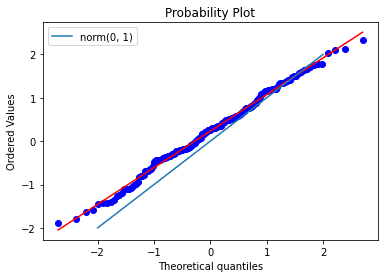

In [1]:
import matplotlib.pyplot as plt
from scipy import stats

data = stats.norm(0.3, 0.8).rvs(200)
# Do these data come from norm(0, 1)?
fig, ax = plt.subplots()
stats.probplot(data,
               dist=stats.norm(0, 1),
               fit=False,
               plot=ax)
ax.plot([-2, 2], [-2, 2],
        label="norm(0, 1)")
ax.legend()

In [2]:
stats.probplot(data,
               dist=stats.norm(0, 1),
               fit=False)

(array([-2.70069508, -2.39117927, -2.21476595, -2.08844273, -1.98865134,
        -1.90545091, -1.83366817, -1.77025272, -1.7132485 , -1.66132288,
        -1.61352545, -1.56915347, -1.52767212, -1.48866446, -1.45179889,
        -1.41680716, -1.38346902, -1.35160134, -1.32105008, -1.29168444,
        -1.26339229, -1.23607681, -1.20965371, -1.18404921, -1.1591983 ,
        -1.13504337, -1.11153314, -1.08862177, -1.06626803, -1.04443478,
        -1.02308837, -1.00219826, -0.9817366 , -0.96167793, -0.94199891,
        -0.9226781 , -0.90369573, -0.88503353, -0.86667459, -0.84860322,
        -0.83080482, -0.8132658 , -0.79597346, -0.77891592, -0.76208206,
        -0.74546144, -0.72904425, -0.71282124, -0.69678371, -0.68092342,
        -0.6652326 , -0.64970389, -0.63433029, -0.61910517, -0.60402223,
        -0.58907547, -0.57425918, -0.55956789, -0.5449964 , -0.53053972,
        -0.51619308, -0.50195192, -0.48781183, -0.47376862, -0.45981823,
        -0.44595676, -0.43218046, -0.41848569, -0.4

In [365]:
20 + 14 + 7 + 12 + 22 + 25

100